<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [10]</a>'.</span>

# VGGT: Visual Geometry Grounded Transformer - Tutorial

This notebook demonstrates the key functionality of VGGT (Visual Geometry Grounded Transformer) for 3D scene reconstruction from images.

## Overview

Visual Geometry Grounded Transformer (VGGT, CVPR 2025) is a feed-forward neural network that directly infers all key 3D attributes of a scene, including extrinsic and intrinsic camera parameters, point maps, depth maps, and 3D point tracks, from one, a few, or hundreds of its views, within seconds.

In [1]:
# Configure matplotlib for high-quality output
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300

## Quick Start

First, let's import the necessary libraries and initialize the VGGT model:

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import sys

# Add the repo path to sys.path
sys.path.append('/Users/speed/Downloads/Paper2Agent/VGGT_Agent/repo/vggt')

from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Check if we have a CUDA device and set appropriate dtype
if torch.cuda.is_available():
    # bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+) 
    dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16
else:
    dtype = torch.float32

print(f"Using dtype: {dtype}")

/Users/speed/Downloads/Paper2Agent/VGGT_Agent/repo/vggt-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu
Using dtype: torch.float32


In [3]:
# Initialize the model and load the pretrained weights.
# This will automatically download the model weights the first time it's run, which may take a while.
print("Loading VGGT model...")
model = VGGT.from_pretrained("facebook/VGGT-1B").to(device)
print("Model loaded successfully!")

Loading VGGT model...


Model loaded successfully!


## Working with Example Images

Let's check what example images are available in the repository:

In [4]:
# Check for example images in the repository
repo_path = "/Users/speed/Downloads/Paper2Agent/VGGT_Agent/repo/vggt"
examples_path = os.path.join(repo_path, "examples")

if os.path.exists(examples_path):
    print("Found examples directory:")
    for item in os.listdir(examples_path):
        item_path = os.path.join(examples_path, item)
        if os.path.isdir(item_path):
            print(f"  {item}/")
            # Check for images subdirectory
            images_subdir = os.path.join(item_path, "images")
            if os.path.exists(images_subdir):
                images = [f for f in os.listdir(images_subdir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                for img in images[:3]:  # Show first 3 images
                    print(f"    images/{img}")
                if len(images) > 3:
                    print(f"    ... and {len(images)-3} more")
            else:
                # Check for images directly in the directory
                images = [f for f in os.listdir(item_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                for img in images[:3]:  # Show first 3 images
                    print(f"    {img}")
                if len(images) > 3:
                    print(f"    ... and {len(images)-3} more")
else:
    print("No examples directory found")

Found examples directory:
  room/
    images/no_overlap_8.jpg
    images/no_overlap_2.jpg
    images/no_overlap_3.jpg
    ... and 5 more
  single_cartoon/
    images/model_was_never_trained_on_single_image_or_cartoon.jpg
  videos/
  llff_fern/
    images/002.png
    images/016.png
    images/017.png
    ... and 17 more
  kitchen/
    images/14.png
    images/00.png
    images/01.png
    ... and 22 more
  single_oil_painting/
    images/model_was_never_trained_on_single_image_or_oil_painting.png
  llff_flower/
    images/002.png
    images/016.png
    images/017.png
    ... and 22 more


Using example directory: room
Selected images: ['no_overlap_1.png', 'no_overlap_2.jpg', 'no_overlap_3.jpg']


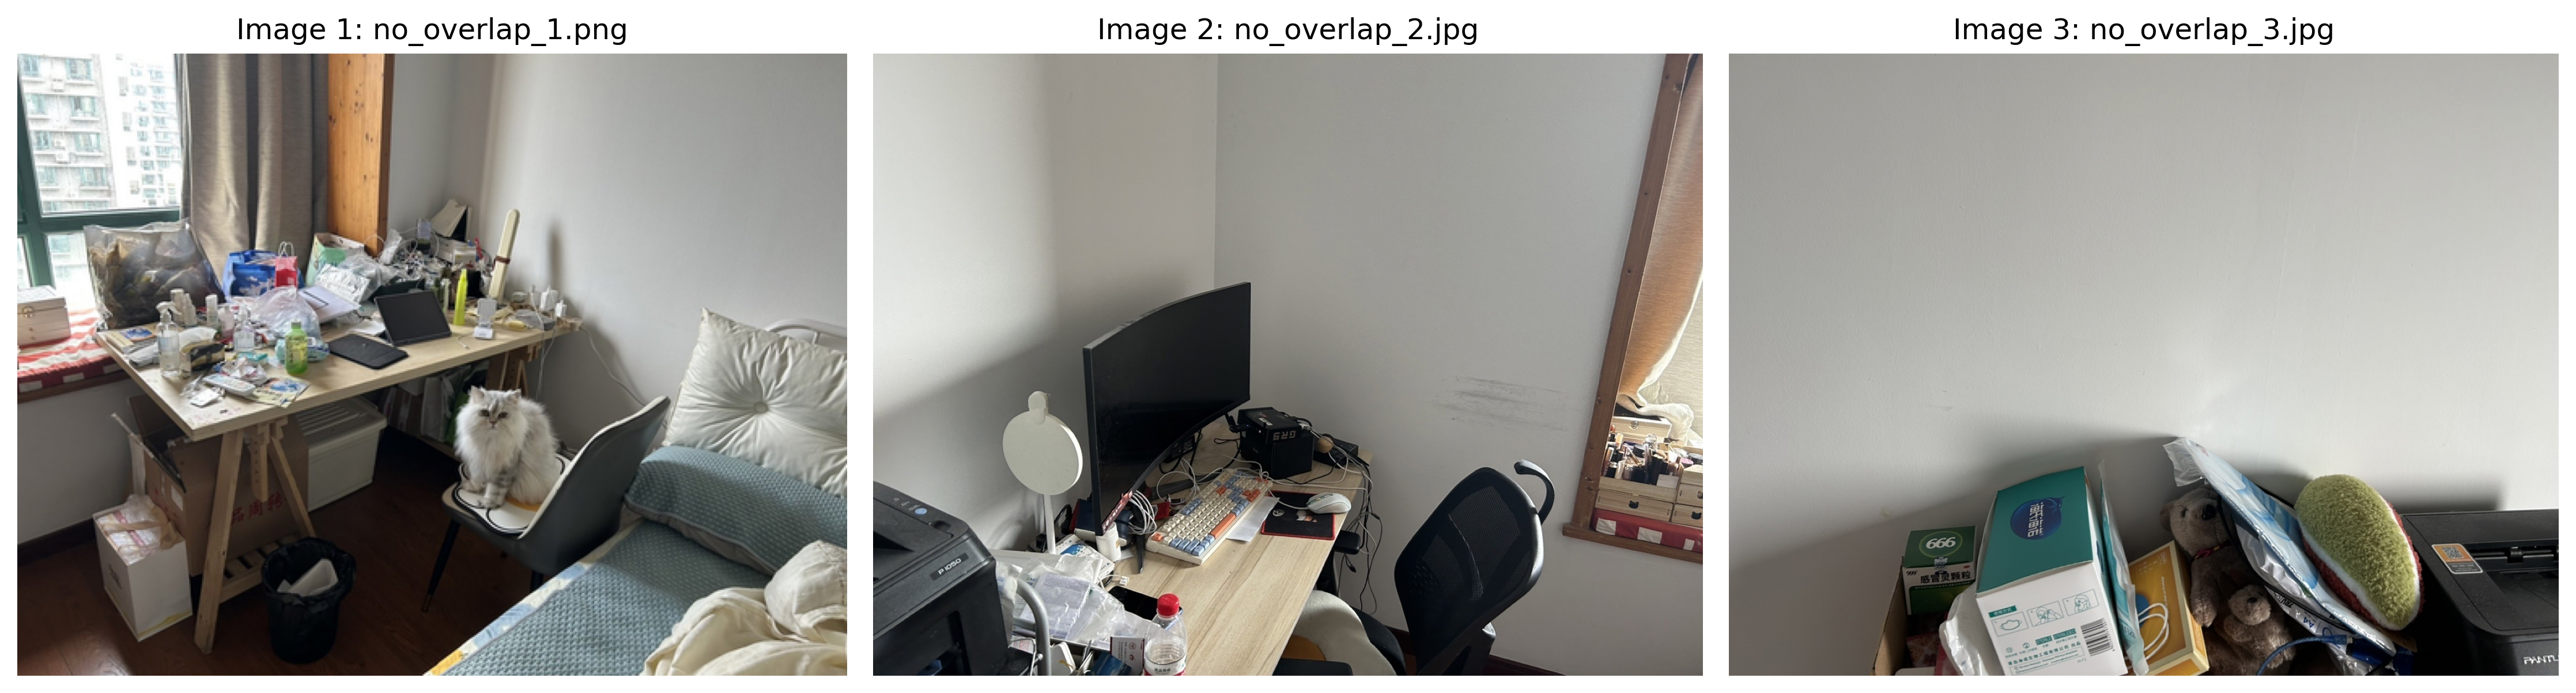

In [5]:
# Let's use images from the first available example directory
example_dirs = [d for d in os.listdir(examples_path) if os.path.isdir(os.path.join(examples_path, d))]
if example_dirs:
    # Use the first example directory
    example_dir = os.path.join(examples_path, example_dirs[0])
    print(f"Using example directory: {example_dirs[0]}")
    
    # Check if images are in a subdirectory called "images"
    images_subdir = os.path.join(example_dir, "images")
    if os.path.exists(images_subdir):
        image_files = [f for f in os.listdir(images_subdir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        image_files = sorted(image_files)  # Sort for consistent ordering
        image_dir = images_subdir
    else:
        # Images are directly in the example directory
        image_files = [f for f in os.listdir(example_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        image_files = sorted(image_files)  # Sort for consistent ordering
        image_dir = example_dir
    
    # Use first 3 images (or all if less than 3)
    selected_images = image_files[:min(3, len(image_files))]
    image_names = [os.path.join(image_dir, img) for img in selected_images]
    
    print(f"Selected images: {selected_images}")
    
    # Display the selected images only if we have images
    if len(selected_images) > 0:
        fig, axes = plt.subplots(1, len(selected_images), figsize=(15, 5))
        if len(selected_images) == 1:
            axes = [axes]
        
        for i, img_path in enumerate(image_names):
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(f"Image {i+1}: {selected_images[i]}")
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No images found in the example directory")
        # Create dummy images for demonstration
        image_names = []
        for i in range(3):
            dummy_img = Image.fromarray(np.random.randint(0, 256, (256, 256, 3), dtype=np.uint8))
            dummy_path = f"/tmp/dummy_image_{i}.png"
            dummy_img.save(dummy_path)
            image_names.append(dummy_path)
        print("Created dummy images for demonstration")
else:
    print("No example directories found, creating dummy images for demonstration")
    # Create dummy images for demonstration
    image_names = []
    for i in range(3):
        dummy_img = Image.fromarray(np.random.randint(0, 256, (256, 256, 3), dtype=np.uint8))
        dummy_path = f"/tmp/dummy_image_{i}.png"
        dummy_img.save(dummy_path)
        image_names.append(dummy_path)
    print("Created dummy images for demonstration")

## Basic VGGT Inference

Now let's run VGGT inference on our selected images:

In [6]:
# Load and preprocess the images
print("Loading and preprocessing images...")
images = load_and_preprocess_images(image_names).to(device)
print(f"Loaded images with shape: {images.shape}")

# Run inference
print("Running VGGT inference...")
with torch.no_grad():
    with torch.cuda.amp.autocast(dtype=dtype) if torch.cuda.is_available() else torch.cuda.amp.autocast():
        # Predict attributes including cameras, depth maps, and point maps.
        predictions = model(images)

print("Inference completed!")
print("Predictions keys:", list(predictions.keys()))

Loading and preprocessing images...
Loaded images with shape: torch.Size([3, 3, 392, 518])
Running VGGT inference...


/var/folders/7q/tx7m0tg12m5cgq7k8z8q2dzw0000gn/T/ipykernel_83790/3749677287.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=dtype) if torch.cuda.is_available() else torch.cuda.amp.autocast():
/Users/speed/Downloads/Paper2Agent/VGGT_Agent/repo/vggt-env/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


/Users/speed/Downloads/Paper2Agent/VGGT_Agent/repo/vggt/vggt/models/vggt.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Inference completed!
Predictions keys: ['pose_enc', 'pose_enc_list', 'depth', 'depth_conf', 'world_points', 'world_points_conf']


## Detailed Usage - Individual Component Predictions

Let's demonstrate how to predict individual components (cameras, depth maps, point maps, and tracks):

In [7]:
from vggt.utils.pose_enc import pose_encoding_to_extri_intri
from vggt.utils.geometry import unproject_depth_map_to_point_map

print("Running detailed component-wise inference...")

with torch.no_grad():
    with torch.cuda.amp.autocast(dtype=dtype) if torch.cuda.is_available() else torch.cuda.amp.autocast():
        images_batch = images[None]  # add batch dimension
        aggregated_tokens_list, ps_idx = model.aggregator(images_batch)
        
    print("\n1. Predicting Camera Parameters...")
    # Predict Cameras
    pose_enc = model.camera_head(aggregated_tokens_list)[-1]
    # Extrinsic and intrinsic matrices, following OpenCV convention (camera from world)
    extrinsic, intrinsic = pose_encoding_to_extri_intri(pose_enc, images_batch.shape[-2:])
    
    print(f"Extrinsic matrices shape: {extrinsic.shape}")
    print(f"Intrinsic matrices shape: {intrinsic.shape}")
    
    print("\n2. Predicting Depth Maps...")
    # Predict Depth Maps
    depth_map, depth_conf = model.depth_head(aggregated_tokens_list, images_batch, ps_idx)
    print(f"Depth map shape: {depth_map.shape}")
    print(f"Depth confidence shape: {depth_conf.shape}")
    
    print("\n3. Predicting Point Maps...")
    # Predict Point Maps
    point_map, point_conf = model.point_head(aggregated_tokens_list, images_batch, ps_idx)
    print(f"Point map shape: {point_map.shape}")
    print(f"Point confidence shape: {point_conf.shape}")
    
    print("\n4. Constructing 3D Points from Depth Maps...")
    # Construct 3D Points from Depth Maps and Cameras
    # which usually leads to more accurate 3D points than point map branch
    point_map_by_unprojection = unproject_depth_map_to_point_map(depth_map.squeeze(0), 
                                                                extrinsic.squeeze(0), 
                                                                intrinsic.squeeze(0))
    print(f"Unprojected point map shape: {point_map_by_unprojection.shape}")
    
    print("\n5. Predicting Point Tracks...")
    # Predict Tracks
    # choose your own points to track, with shape (N, 2) for one scene
    query_points = torch.FloatTensor([[100.0, 200.0], 
                                      [60.72, 259.94]]).to(device)
    track_list, vis_score, conf_score = model.track_head(aggregated_tokens_list, images_batch, ps_idx, query_points=query_points[None])
    print(f"Track list length: {len(track_list)}")
    print(f"Visibility score shape: {vis_score.shape}")
    print(f"Confidence score shape: {conf_score.shape}")

Running detailed component-wise inference...


/var/folders/7q/tx7m0tg12m5cgq7k8z8q2dzw0000gn/T/ipykernel_83790/2039666370.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=dtype) if torch.cuda.is_available() else torch.cuda.amp.autocast():



1. Predicting Camera Parameters...


Extrinsic matrices shape: torch.Size([1, 3, 3, 4])
Intrinsic matrices shape: torch.Size([1, 3, 3, 3])

2. Predicting Depth Maps...


Depth map shape: torch.Size([1, 3, 392, 518, 1])
Depth confidence shape: torch.Size([1, 3, 392, 518])

3. Predicting Point Maps...


Point map shape: torch.Size([1, 3, 392, 518, 3])
Point confidence shape: torch.Size([1, 3, 392, 518])

4. Constructing 3D Points from Depth Maps...
Unprojected point map shape: (3, 392, 518, 3)

5. Predicting Point Tracks...


Track list length: 4
Visibility score shape: torch.Size([1, 3, 2])
Confidence score shape: torch.Size([1, 3, 2])


## Visualizing Results

Let's visualize some of the predicted results:

Visualizing depth maps...


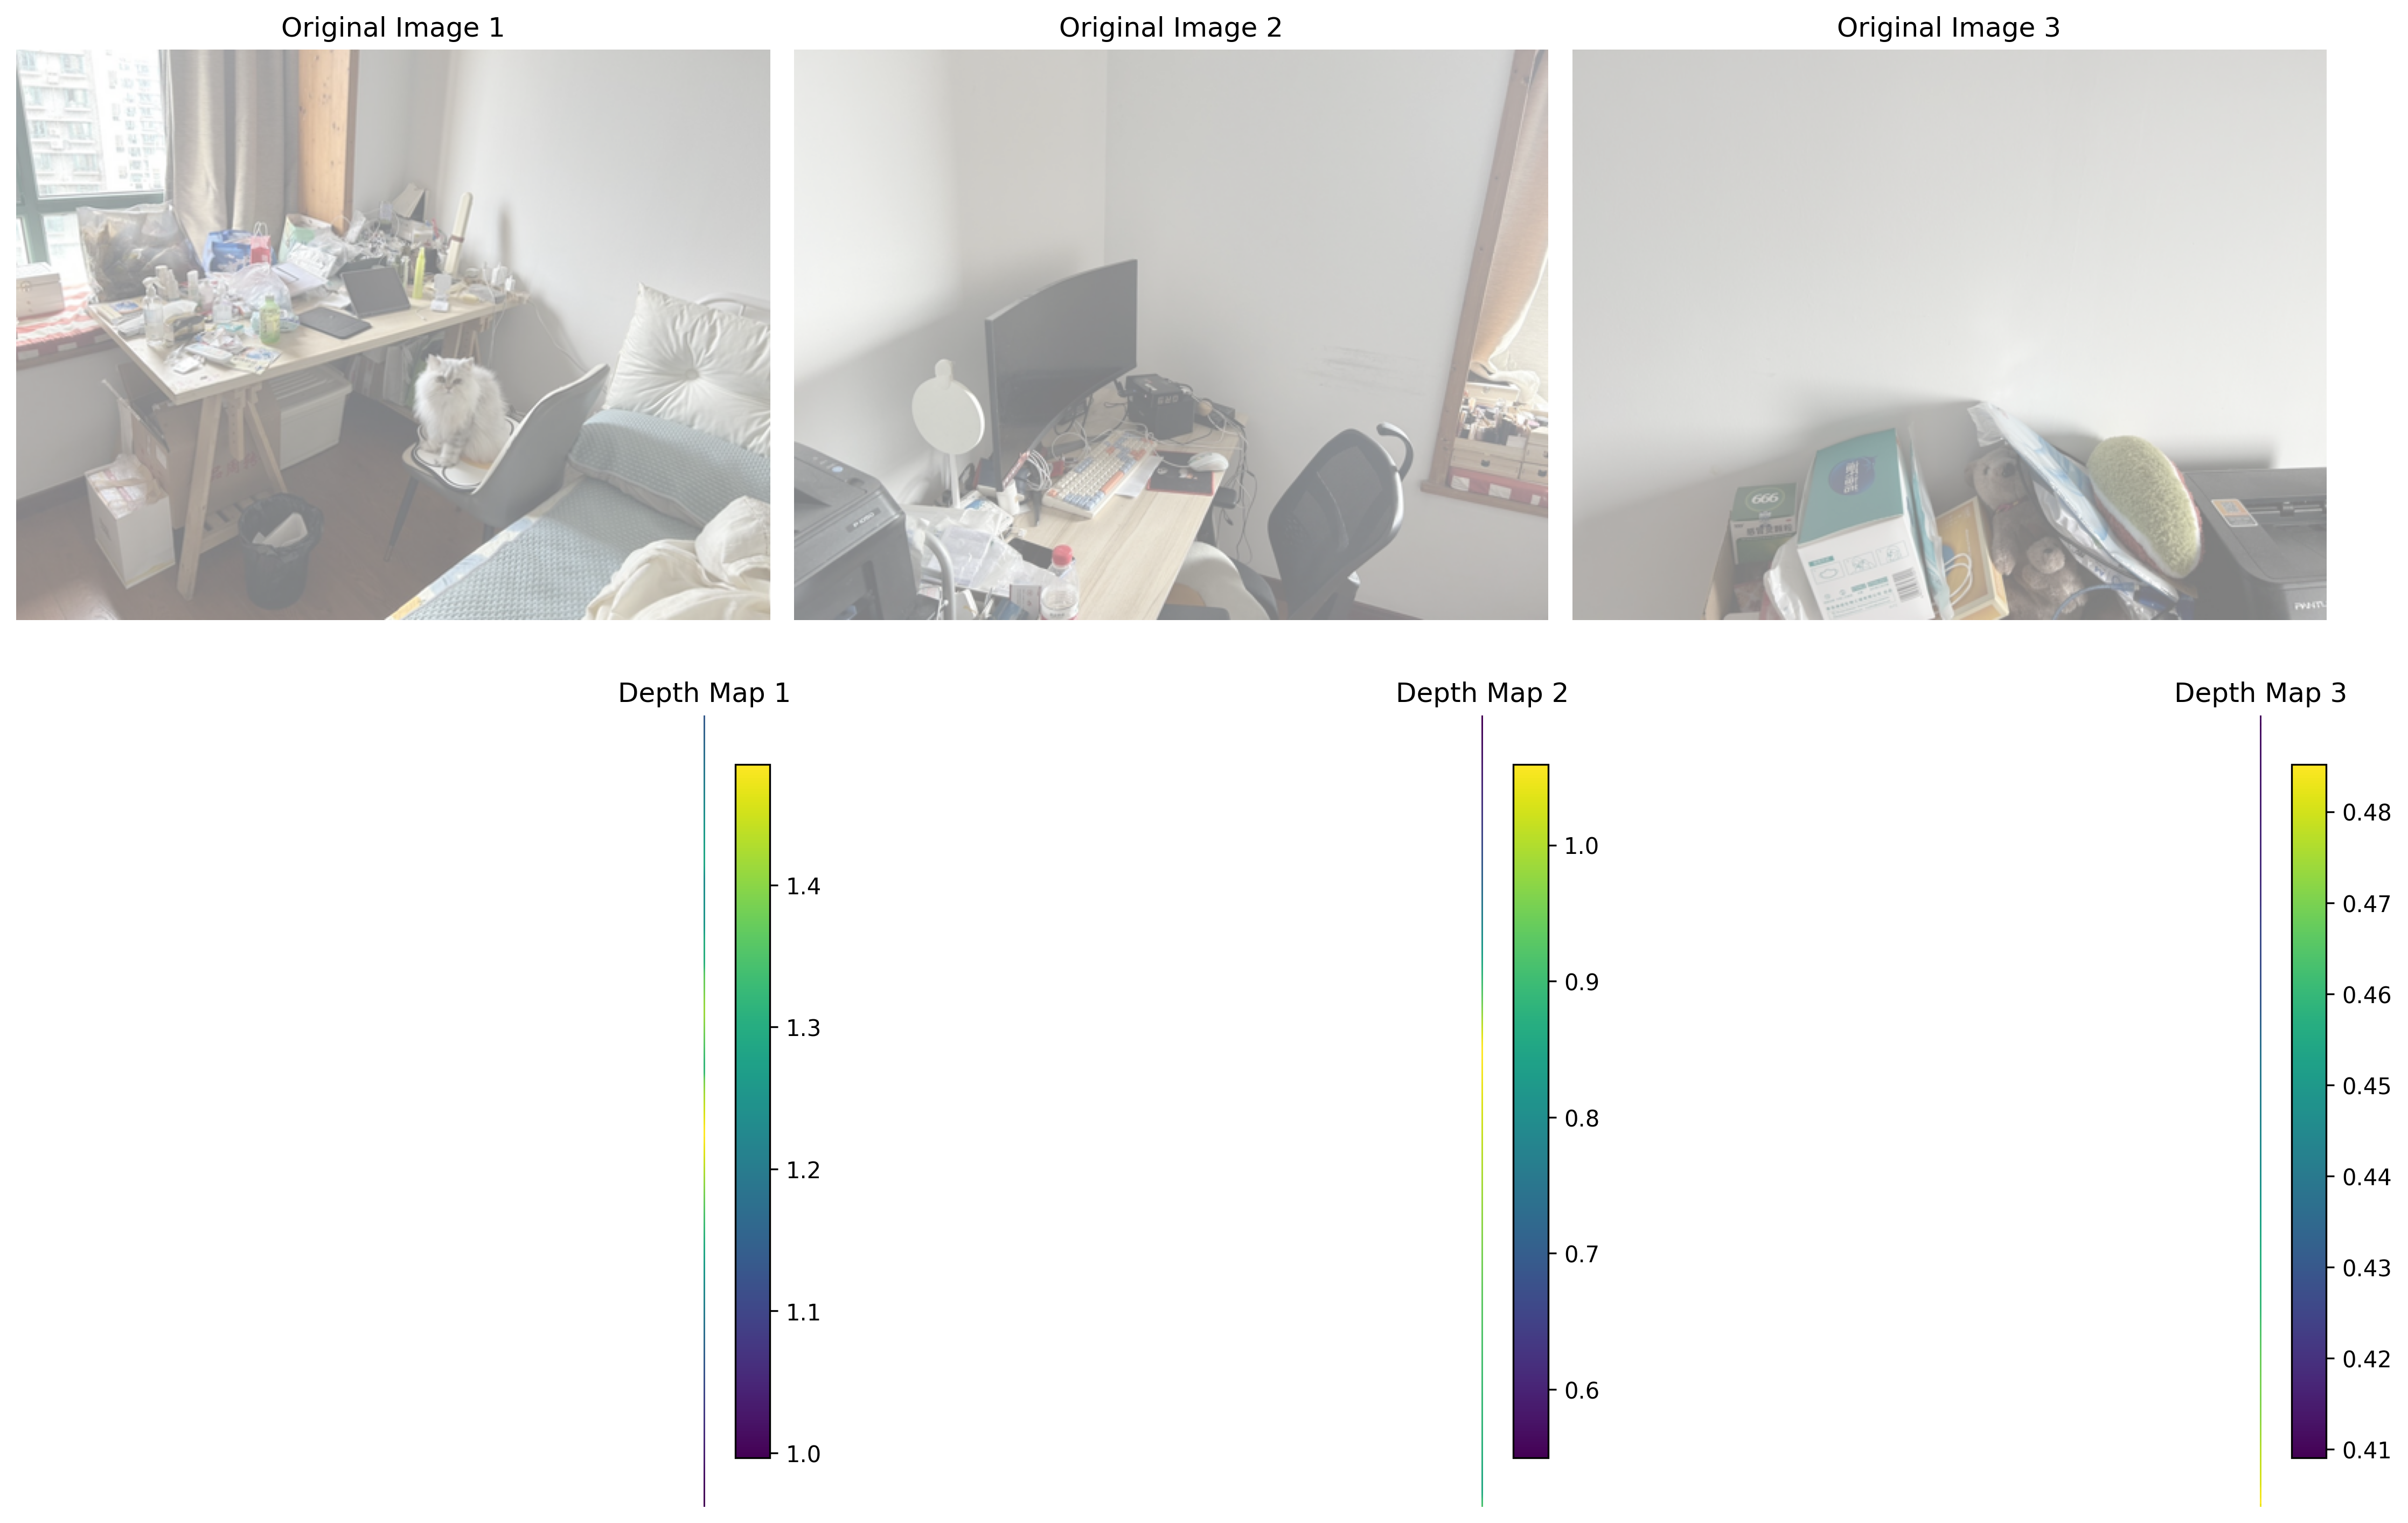

In [8]:
# Visualize depth maps
print("Visualizing depth maps...")

num_images = depth_map.shape[1]
fig, axes = plt.subplots(2, num_images, figsize=(5*num_images, 10))
if num_images == 1:
    axes = axes.reshape(-1, 1)

for i in range(num_images):
    # Original image
    original_img = images[i].permute(1, 2, 0).cpu().numpy()
    # Denormalize the image (assuming it was normalized)
    original_img = (original_img + 1) / 2  # Convert from [-1, 1] to [0, 1]
    original_img = np.clip(original_img, 0, 1)
    
    axes[0, i].imshow(original_img)
    axes[0, i].set_title(f"Original Image {i+1}")
    axes[0, i].axis('off')
    
    # Depth map
    depth = depth_map[0, i, 0].cpu().numpy()  # Remove batch and channel dimensions
    im = axes[1, i].imshow(depth, cmap='viridis')
    axes[1, i].set_title(f"Depth Map {i+1}")
    axes[1, i].axis('off')
    plt.colorbar(im, ax=axes[1, i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [9]:
# Print camera intrinsic and extrinsic parameters
print("Camera Parameters:")
print("=" * 50)

for i in range(extrinsic.shape[1]):
    print(f"\nCamera {i+1}:")
    print(f"Intrinsic matrix:")
    print(intrinsic[0, i].cpu().numpy())
    print(f"Extrinsic matrix:")
    print(extrinsic[0, i].cpu().numpy())

Camera Parameters:

Camera 1:
Intrinsic matrix:
[[448.0356    0.      259.     ]
 [  0.      449.60745 196.     ]
 [  0.        0.        1.     ]]
Extrinsic matrix:
[[ 1.0000000e+00 -5.2682910e-05  1.7658927e-05  1.3315367e-05]
 [ 5.2680960e-05  1.0000000e+00  1.1037274e-04  1.1690050e-05]
 [-1.7664745e-05 -1.1037181e-04  1.0000000e+00 -1.7174703e-04]]

Camera 2:
Intrinsic matrix:
[[437.09094   0.      259.     ]
 [  0.      438.3995  196.     ]
 [  0.        0.        1.     ]]
Extrinsic matrix:
[[ 0.44642174 -0.36896777  0.81521183  0.03968985]
 [ 0.22540407  0.92802274  0.29659188  0.06154551]
 [-0.865968    0.05134702  0.49745637 -0.12626342]]

Camera 3:
Intrinsic matrix:
[[436.51367   0.      259.     ]
 [  0.      438.164   196.     ]
 [  0.        0.        1.     ]]
Extrinsic matrix:
[[-0.5793017  -0.3628609   0.7298914   0.10637971]
 [ 0.22484377  0.78957075  0.5709845   0.1193597 ]
 [-0.78348887  0.4948838  -0.37581265 -0.05305989]]


<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [10]:
# Visualize point tracks
print("Visualizing point tracks...")

fig, axes = plt.subplots(1, num_images, figsize=(5*num_images, 5))
if num_images == 1:
    axes = [axes]

for i in range(num_images):
    # Original image
    original_img = images[i].permute(1, 2, 0).cpu().numpy()
    original_img = (original_img + 1) / 2  # Denormalize
    original_img = np.clip(original_img, 0, 1)
    
    axes[i].imshow(original_img)
    
    # Plot tracked points
    if i < len(track_list[0]):
        tracks = track_list[0][i].cpu().numpy()  # [num_query_points, 2]
        vis = vis_score[0, i].cpu().numpy()     # [num_query_points]
        
        for j, (track_point, visibility) in enumerate(zip(tracks, vis)):
            if visibility > 0.5:  # Only show visible tracks
                axes[i].plot(track_point[0], track_point[1], 'ro', markersize=8)
                axes[i].text(track_point[0]+5, track_point[1]+5, f'P{j+1}', 
                           color='red', fontsize=12, fontweight='bold')
    
    axes[i].set_title(f"Image {i+1} with Tracks")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Print track information
print("\nTrack Information:")
for j in range(query_points.shape[0]):
    print(f"\nQuery Point {j+1}: ({query_points[j, 0]:.1f}, {query_points[j, 1]:.1f})")
    for i in range(len(track_list[0])):
        if i < len(track_list[0]):
            track_point = track_list[0][i][j].cpu().numpy()
            visibility = vis_score[0, i, j].cpu().numpy()
            confidence = conf_score[0, i, j].cpu().numpy()
            print(f"  Image {i+1}: ({track_point[0]:.1f}, {track_point[1]:.1f}), "
                  f"vis={visibility:.3f}, conf={confidence:.3f}")

Visualizing point tracks...


TypeError: only length-1 arrays can be converted to Python scalars

Error in callback <function _draw_all_if_interactive at 0x113e86a20> (for post_execute), with arguments args (),kwargs {}:


TypeError: only length-1 arrays can be converted to Python scalars

TypeError: only length-1 arrays can be converted to Python scalars

<Figure size 4500x1500 with 3 Axes>

## Alternative Model Loading

If you encounter issues with automatic downloading, you can manually load the model:

In [ ]:
# Alternative method to load the model manually
print("Demonstrating alternative model loading method...")

try:
    # Create a new model instance
    model_alt = VGGT()
    
    # Load weights from URL
    _URL = "https://huggingface.co/facebook/VGGT-1B/resolve/main/model.pt"
    print(f"Loading model weights from: {_URL}")
    
    state_dict = torch.hub.load_state_dict_from_url(_URL, map_location=device)
    model_alt.load_state_dict(state_dict)
    model_alt.to(device)
    
    print("Alternative model loading successful!")
    
except Exception as e:
    print(f"Alternative loading failed: {e}")
    print("This is expected if the model was already loaded successfully above.")

## Summary

This tutorial demonstrated the core functionality of VGGT:

1. **Model Loading**: How to initialize and load the pretrained VGGT model
2. **Image Processing**: Loading and preprocessing images for VGGT inference
3. **Basic Inference**: Running complete VGGT inference with a single forward pass
4. **Detailed Inference**: Accessing individual prediction components:
   - Camera parameters (extrinsic and intrinsic matrices)
   - Depth maps with confidence scores
   - Point maps with confidence scores
   - Point tracks with visibility and confidence scores
5. **Visualization**: Displaying depth maps and tracked points
6. **Alternative Loading**: Manual model weight loading for troubleshooting

VGGT enables fast, accurate 3D scene reconstruction from multiple views, providing all essential 3D attributes needed for downstream applications like Gaussian Splatting, NeRF training, or COLMAP-based reconstruction pipelines.